In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import statsmodels.api as sm

n_states = 3
factor_labels = ["mktrf", "smb", "hml", "rmw", "cma"]

In [2]:
hm_mu = np.array([
    [0.0102,  0.003,  -0.0004,  0.0027, -0.0003],
    [0.0384,  0.0115, -0.0315, -0.0044, -0.0208],
    [-0.0306, -0.0063,  0.0353,  0.0073,  0.0278],
])

hm_covars = np.array([
    [0.0011, 0.0006, 0.0004, 0.0002, 0.0002],
    [0.0037, 0.0029, 0.002, 0.0018, 0.0007],
    [0.0031, 0.0015, 0.001, 0.0012, 0.0005]]
)

hm_transmat = np.array([
    [0.8940, 0.0326, 0.0734],
    [0.3089, 0.3903, 0.3008],
    [0.2739, 0.1894, 0.5367],
])

hm_startprob = np.array([1., 0., 0.])

In [3]:
gen_model = GaussianHMM(n_components=n_states, covariance_type="diag", random_state=0)
gen_model.startprob_ = hm_startprob
gen_model.transmat_ = hm_transmat
gen_model.means_ = hm_mu
gen_model.covars_ = hm_covars

# Generate samples
X, Z = gen_model.sample(500)
G = gen_model.predict_proba(X)

In [4]:
loadings_dist = {
    "mktrf": {
        "mu": np.array([1.05630998, 1.10688552, 1.05185785]),
        "cov": np.array([
            [0.07798565, 0.05284498, 0.05661484],
            [0.05284498, 0.10782596, 0.06232454],
            [0.05661484, 0.06232454, 0.09207952],
        ]),
    },
    "smb": {
        "mu": np.array([0.07532815, -0.02621203, 0.18178004]),
        "cov": np.array([
            [0.21250835, 0.19781977, 0.12225472],
            [0.19781977, 0.3636413,  0.11793616],
            [0.12225472, 0.11793616, 0.18758591],
        ]),
    },
    "hml": {
        "mu": np.array([-0.22068672, -0.00936257, -0.03324693]),
        "cov": np.array([
            [0.33037601, 0.25409194, 0.25043007],
            [0.25409194, 0.42383169, 0.24550376],
            [0.25043007, 0.24550376, 0.28506024],
        ]),
    },
    "rmw": {
        "mu": np.array([0.02394466, 0.11522831, 0.207024]),
        "cov": np.array([
            [0.31042222, 0.23260132, 0.13294201],
            [0.23260132, 0.67021979, 0.24520647],
            [0.13294201, 0.24520647, 0.20589327],
        ]),
    },
    "cma": {
        "mu": np.array([-0.28897857, -0.10714733, 0.05009913]),
        "cov": np.array([
            [0.44909993, 0.23492989, 0.17437237],
            [0.23492989, 0.68808267, 0.2484368],
            [0.17437237, 0.2484368,  0.29755618],
        ]),
    },
}

# TODO:
The problem with this framework is that we are assuming that all the betas values are independent (the draw of the mktrf loading in regime 1 is independent from the mktrf loading in regime 2, when we know that is not true), across regimes, and within the same regime the loading structure is completely independent (mkrtf has no relationshop with smb, for example - even within the same regime).


- I need to increase the window required to estimate betas (20 years of data at least? that way it will include the financial crisis as well)
- Also, the covariance and means of each paramter have to be estimated using weighted statistics (DescrStatsW)
- What do I do with the outliers? most of these massive differences (are due to spikes in returns)

In [5]:
n_stocks = 1000

_midx = pd.MultiIndex.from_tuples([(x, i) for x in loadings_dist.keys() for i in range(n_states)], names=['factor', 'state'])
true_loadings = pd.DataFrame(index=_midx, columns=range(n_stocks))

for fctr in loadings_dist.keys():
    _vals = np.random.multivariate_normal(mean=loadings_dist[fctr]["mu"], cov=loadings_dist[fctr]["cov"], size=n_stocks)
    true_loadings.loc[fctr] = _vals.T

true_loadings.columns.name = "stock"
true_loadings = true_loadings.stack()

In [6]:
R = np.zeros((X.shape[0], n_stocks))
E = np.random.normal(loc=0, scale=np.sqrt(.013), size=R.shape)
for t, s_t in enumerate(Z):
    B = true_loadings.xs(s_t, level="state")
    x_t = pd.Series(X[t], factor_labels)
    x_t.index.name = "factor"
    R[t] += B.mul(x_t).groupby("stock").sum()

# R += E


In [7]:
collect_params = {}

hmm = GaussianHMM(
    n_components=n_states,
    covariance_type="diag",
    random_state=0
)
hmm.fit(X)
G_hat = hmm.predict_proba(X)

for i in range(n_stocks):
    y = R[:, i]
    for s in range(n_states):
        # mdl = sm.WLS(y, sm.add_constant(pd.DataFrame(X, columns=factor_labels)), weights=G_hat[:, s])
        mdl = sm.WLS(y, sm.add_constant(pd.DataFrame(X, columns=factor_labels)), weights=G[:, s])
        
        # TODO: using the actual posterior probs for now until we nail down the issue
        
        collect_params[(s, i)] = mdl.fit().params

est_loadings = pd.DataFrame.from_dict(collect_params)
est_loadings.columns.names = ['state', 'stock']
est_loadings.index.name = 'factor'
est_loadings = est_loadings.melt(ignore_index=False).reset_index().set_index(['stock', 'state', 'factor']).squeeze()
est_loadings.name = 'estimated'

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


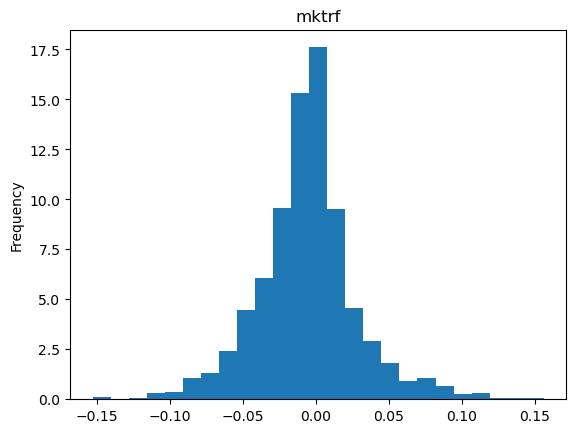

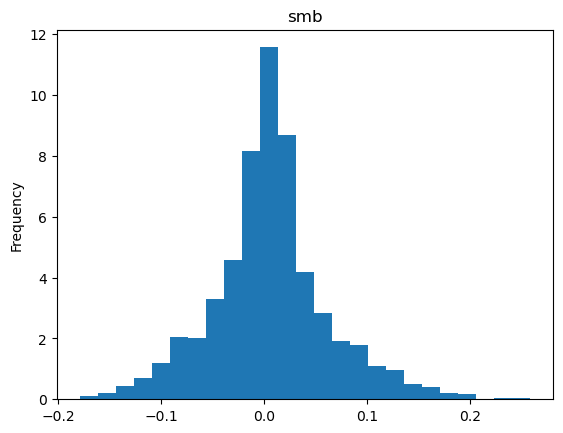

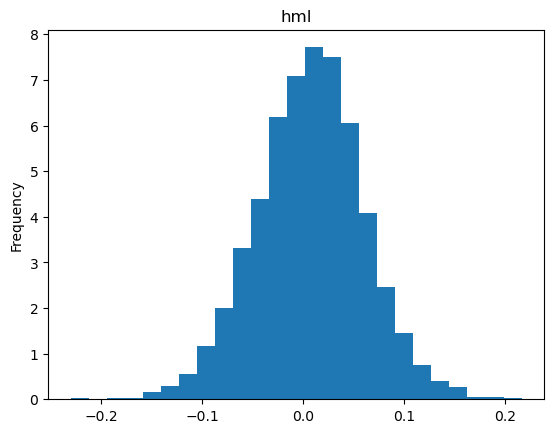

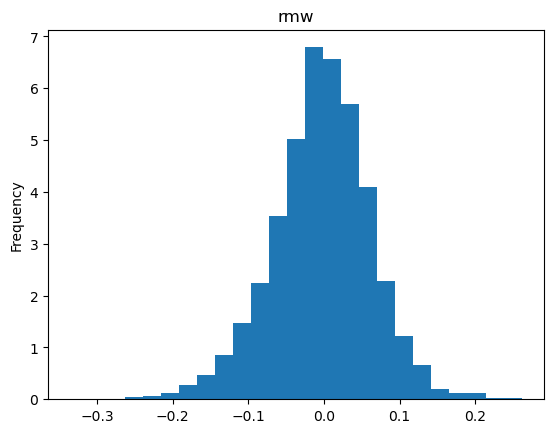

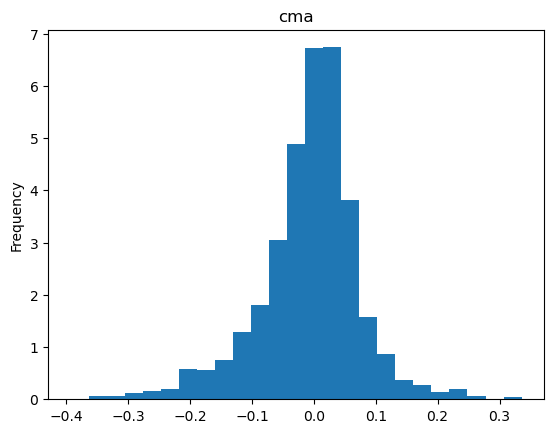

In [8]:
delta_loadings = (est_loadings.loc[pd.IndexSlice[:, :, factor_labels]] - true_loadings)

for fctr in factor_labels:
    x = delta_loadings / true_loadings
    delta_loadings.xs(fctr, level=2).plot.hist(bins=25, density=True)
    plt.gca().set_title(fctr)
    plt.show()

In [9]:
df = true_loadings.to_frame("true").join(est_loadings.to_frame("hat"))
df["delta"] = df["hat"] - df["true"]
df["abs_delta"] = df["delta"].abs()
df.xs("mktrf", level="factor").sort_values("abs_delta", ascending=False).head(5)

true       hat     delta abs_delta
state stock                                        
2     187    0.694541  0.850685  0.156144  0.156144
      658    1.477338  1.324407 -0.152931  0.152931
      447    1.738078  1.585541 -0.152537  0.152537
      328     1.31049  1.161706 -0.148784  0.148784
      662    0.322948  0.470686  0.147738  0.147738

<Axes: >

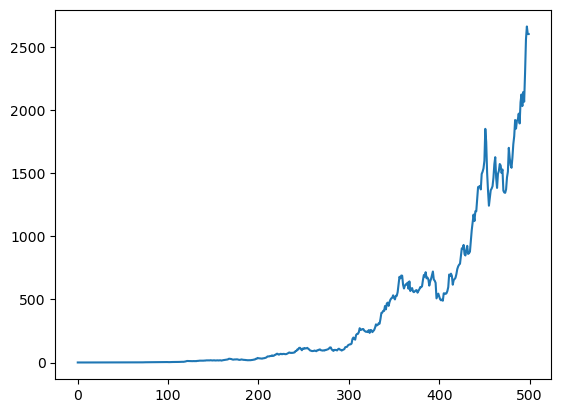

In [10]:
pd.Series(R[:, 856]).add(1).cumprod().plot()

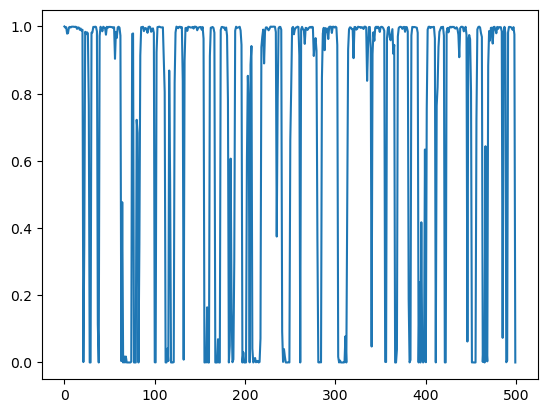

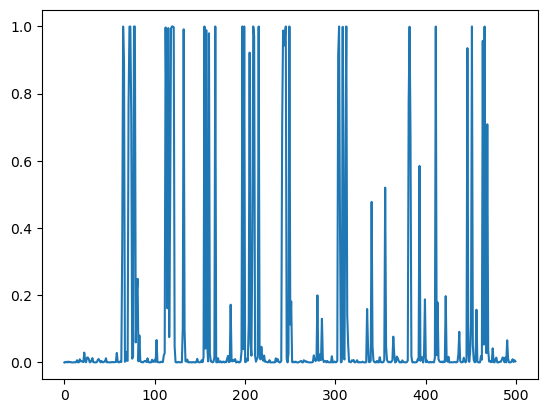

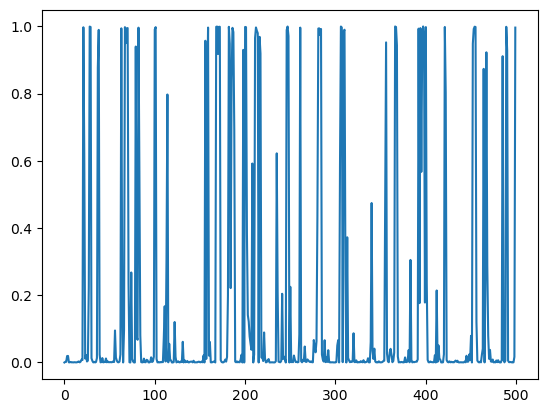

In [11]:
for s in range(n_states):
    plt.plot(G[:, s])
    plt.show()

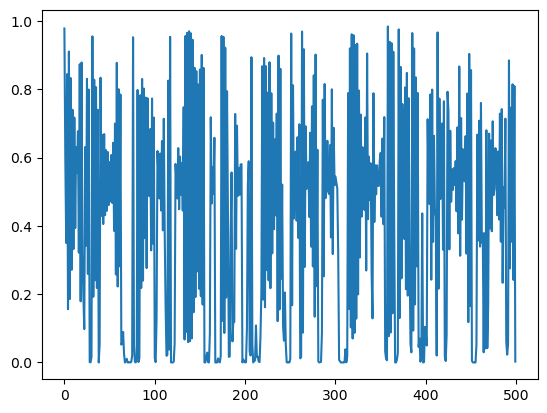

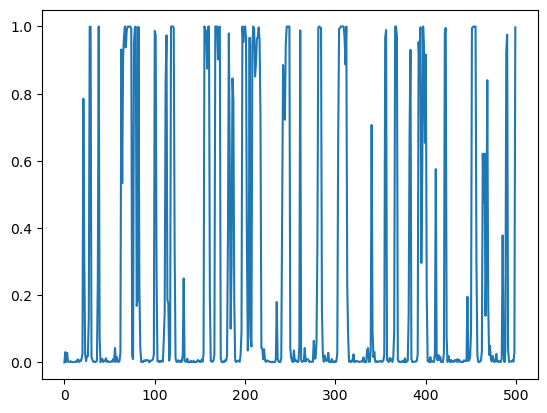

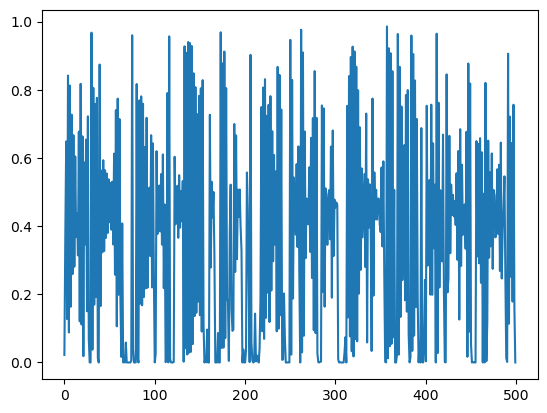

In [12]:
for s in range(n_states):
    plt.plot(G_hat[:, s])
    plt.show()

In [13]:
mdl = sm.WLS(y, sm.add_constant(pd.DataFrame(X, columns=factor_labels)), weights=G_hat[:, s])
collect_params[(s, i)] = mdl.fit().params